# Sentiment analysis of NER extacted sentences from short stories


In [1]:
!pip install tensorflow-gpu torch pandas numpy scikit-learn transformers

     |████████████████████████████████| 497.5 MB 25 kB/s 
     |████████████████████████████████| 4.0 MB 37.0 MB/s 
     |████████████████████████████████| 462 kB 46.9 MB/s 
     |████████████████████████████████| 6.6 MB 33.9 MB/s 
     |████████████████████████████████| 596 kB 44.9 MB/s 
     |████████████████████████████████| 880 kB 42.9 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=77802748d2ef950fab2ba451422f9a866bafc446def679038f8c0252e3b2e12b
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### I/O device registering

Current working directory is set to `/content` by default. You can also give access to your Google Drive to save models/results/... there.

In [118]:
from google.colab import drive
drive.mount("/content/drive/")

# Access your Drive data using folder '/content/drive/MyDrive'

!ls -lah /content/drive/MyDrive/NLP-Project/

Mounted at /content/drive/
total 8.0K
drwx------ 2 root root 4.0K May  4 10:34 data
drwx------ 2 root root 4.0K May  4 10:35 ner


### GPU device selection review

You can directly use system command `nvidia-smi` or use Python library (e.g. Tensorflow or PyTorch) to check this.

In [3]:
!nvidia-smi

Wed May  4 12:18:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import tensorflow as tf
import os
print(f"Tensorflow version: {tf.__version__}")

# Restrict TensorFlow to only allocate 4GBs of memory on the first GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(f"The system contains '{len(gpus)}' Physical GPUs and '{len(logical_gpus)}' Logical GPUs")
  except RuntimeError as e:
    print(e)
else:
    print(f"Your system does not contain a GPU that could be used by Tensorflow!")

Tensorflow version: 2.8.0
The system contains '1' Physical GPUs and '1' Logical GPUs


## Sentiment analysis proof of concept

Using the sentances grouped by NER tagging. We calculate the normalised average of a persons sentiment.

For the moment we are using the default Huggingface pipline to obtain proof of concept results.

If the results are promisin we shall create our finetuned implementation/arhicheture.


In [101]:
# Imports
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


from transformers import pipeline
from pathlib import PurePath
from matplotlib.collections import PatchCollection


In [120]:
# Character object

class CharacterData:
  def __init__(self, character, frequency, appearances):
    self.character = character
    self.frequency = len(appearances) # int(frequency) extraction was not accurate
    self.appearances = appearances
    self.appearances_scores = []
    self.sentiment_class = None
    self.sentiment_score = None

  def get_info(self):
    return self.character, self.frequency, self.sentiment_class, self.sentiment_score

  def print_info(self):
    print(f"{'':->150}")
    print(f"Character name: {self.character}")
    print(f"Frequency in story: {self.frequency}")
    if self.sentiment_class:
      print(f"Classified as {self.sentiment_class} with average score of: {self.sentiment_score}")
    print(f"{'':->150}")

  def get_appearances(self):
    return self.appearances

  def add_appearances_score(self, appearances_score):
    self.appearances_scores.extend(appearances_score)
    if len(self.appearances_scores) == self.frequency:
      self.calculate_statistics()

  def calculate_statistics(self, mode = "Average"):
    if mode == "Average":
      negative_average_score = 0
      positive_average_score = 0
      for score in self.appearances_scores:
        if score["label"] == "NEGATIVE":
          negative_average_score += float(score["score"]) / self.frequency
        elif score["label"] == "POSITIVE":
          positive_average_score += float(score["score"]) / self.frequency
        else:
          raise ValueError("Label unknown!")
      
      if negative_average_score >= positive_average_score:
        self.sentiment_class = "NEGATIVE"
        self.sentiment_score = negative_average_score
      else:
        self.sentiment_class = "POSITIVE"
        self.sentiment_score = positive_average_score
      
    elif mode == "Mean":
      negative_weighted_average = 0
      positive_weighted_average = 0
      sum_of_negative_scores = 0
      sum_of_positive_scores = 0
      for score in self.appearances_scores:
        if score["label"] == "NEGATIVE":
          negative_weighted_average += float(score["score"]) * 1
          sum_of_negative_scores += float(score["score"])
        elif score["label"] == "POSITIVE":
          positive_weighted_average += float(score["score"]) * 1
          sum_of_positive_scores += float(score["score"])
        else:
          raise ValueError("Label unknown!")

      # Calculate the mean
      if sum_of_negative_scores != 0:
        negative_weighted_average /= sum_of_negative_scores
      if sum_of_positive_scores != 0:
        positive_weighted_average /= sum_of_positive_scores

      if negative_weighted_average >= positive_weighted_average:
        self.sentiment_class = "NEGATIVE"
        self.sentiment_score = negative_weighted_average
      else:
        self.sentiment_class = "POSITIVE"
        self.sentiment_score = positive_weighted_average

  def get_dict(self):
    return {
        "character": self.character,
        "frequency": self.frequency,
        "appearances": self.appearances,
        "appearances_scores": self.appearances_scores,
        "sentiment_class": self.sentiment_class,
        "sentiment_score": self.sentiment_score
    }


In [121]:
# Read in the data

def decode_data(path, filename):
  # Output placeholder  
  story_data = []
  # Read the file
  with open(PurePath(path, filename)) as f:
    data = json.loads(f.read())
    #print(data)
    for character in data:
      if int(character["frequency"]) != 0:
        story_data.append(CharacterData(character["character"], character["frequency"], character["appearances"]))

  return story_data

# Write out the data

def encode_data(path, filename, output):
  # Export the json file
  json_dump = json.dumps(output)

  with open(PurePath(path, "sentiment", filename), "w") as f:
    f.write(json_dump)

In [122]:
# Sentiment pipeline

def sentiment_analysis(classifier, character_data):
  for appearance in character_data.get_appearances():
    #print(appearance)
    result = classifier(appearance)
    
    # Add the score to the character_data
    character_data.add_appearances_score(result)


In [137]:
# Plot the data

def label(xy, text):
    y = xy[1] - 0.15  # Shift y-value for label so that it's below the artist
    plt.text(xy[0], y, text, ha="center", family='sans-serif', size=14)

def plot_data(story_data):
  fig, ax = plt.subplots()
  # Create 2x2 grid to plot the artists
  grid = np.mgrid[0.2:0.8:2j, 0.2:0.8:2j].reshape(2, -1).T
  
  patches = []
  colors = []

  for i, character in enumerate(story_data):
    name, freq, sentiment, score = character.get_info()

    color = "g"
    if sentiment == "NEGATIVE":
      color = "r"

    # Add a circle
    circle = mpatches.Circle(grid[i], 0.1, ec = "none", color = color)
    patches.append(circle)
    label(grid[i], f"{name} ({score:.2f})")

  collection = PatchCollection(patches, match_original = True)
  ax.add_collection(collection)

  plt.axis('equal')
  plt.axis('off')
  plt.tight_layout()

  plt.show()

In [133]:
# Main execution

def main(path):
  path_ner = PurePath(path, "ner")

  for file in os.listdir(path_ner):
    if os.path.isfile(PurePath(path_ner, file)):
      filename = PurePath(file)

      print(f"{'':_>150}")
      print(filename)
      print(f"{'':_>150}\n")

      # Get the data
      story_data = decode_data(path_ner, filename)
      #print(story_data)

      # Sentiment analysis pipeline
      classifier = pipeline("sentiment-analysis")

      # Placeholder for output
      output = []

      # Run sentiment analysis for all the characters in the story
      for character_data in story_data:
        character_data.print_info()
        print("Running sentiment analysis...")
        sentiment_analysis(classifier, character_data)
        character_data.print_info()

        # Add data to output
        output.append(character_data.get_dict())

      # Output to json
      encode_data(path, filename, output)

      # Plot the results
      plot_data(story_data)
    

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


______________________________________________________________________________________________________________________________________________________
The Lady or the Tiger Original.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: frank
Frequency in story: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: frank
Frequency in story: 1
Classified as NEGATIVE with average score of: 0.9873487949371338
-------------------------

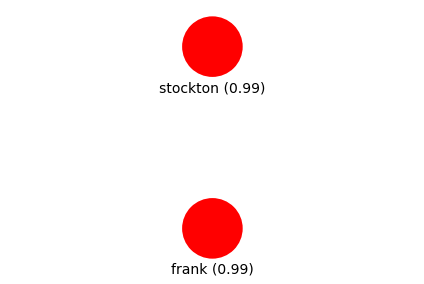

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


______________________________________________________________________________________________________________________________________________________
Henry_Red_Chief.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: dorset
Frequency in story: 11
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: dorset
Frequency in story: 11
Classified as NEGATIVE with average score of: 0.783493090759624
-------------------------------------

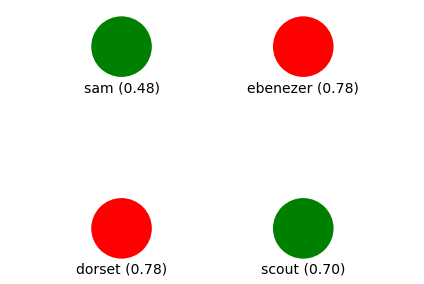

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


______________________________________________________________________________________________________________________________________________________
LeiningenVstheAnts.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: carl
Frequency in story: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: carl
Frequency in story: 1
Classified as NEGATIVE with average score of: 0.9975638389587402
---------------------------------------

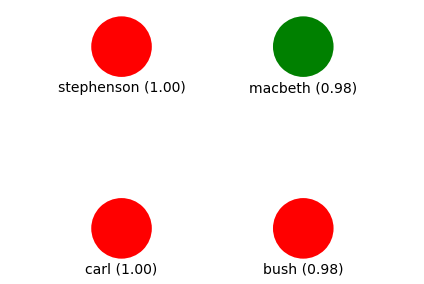

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


______________________________________________________________________________________________________________________________________________________
the_gift_of_the_magi_0_Henry.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: jim
Frequency in story: 26
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: jim
Frequency in story: 26
Classified as POSITIVE with average score of: 0.49271239225681007
----------------------------

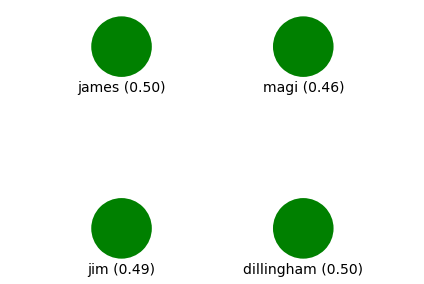

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


______________________________________________________________________________________________________________________________________________________
The Most Dangerous Game.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: rainsford
Frequency in story: 130
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: rainsford
Frequency in story: 130
Classified as POSITIVE with average score of: 0.6191131651401521
--------------------

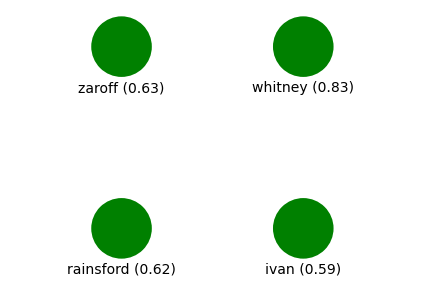

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


______________________________________________________________________________________________________________________________________________________
Hills Like White Elephants.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: ernest
Frequency in story: 2
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: ernest
Frequency in story: 2
Classified as POSITIVE with average score of: 0.496279776096344
----------------------------

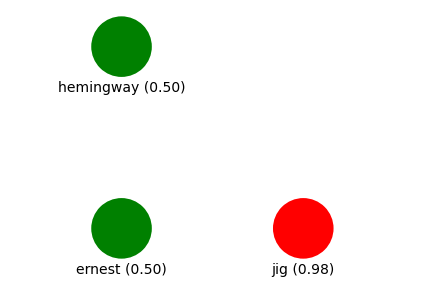

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


______________________________________________________________________________________________________________________________________________________
The Tell Tale Heart.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: edgar
Frequency in story: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: edgar
Frequency in story: 1
Classified as POSITIVE with average score of: 0.9997281432151794
------------------------------------

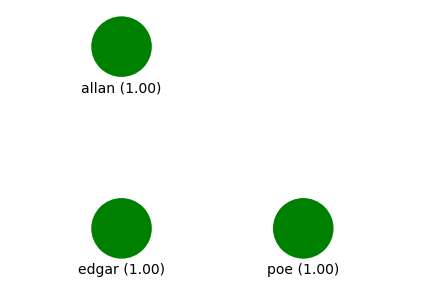

In [138]:
 # imapbook execution 
path = "/content/drive/MyDrive/NLP-Project/data/imapbook/"

main(path)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


______________________________________________________________________________________________________________________________________________________
Howard_TheDevilinIron.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: conan
Frequency in story: 73
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: conan
Frequency in story: 73
Classified as POSITIVE with average score of: 0.486595679635871
---------------------------------

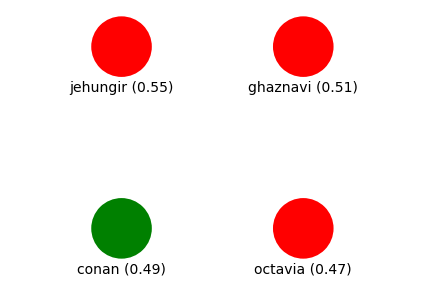

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


______________________________________________________________________________________________________________________________________________________
Howard_ShadowsintheMoonlight.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: conan
Frequency in story: 78
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: conan
Frequency in story: 78
Classified as NEGATIVE with average score of: 0.4834871490796407
-------------------------

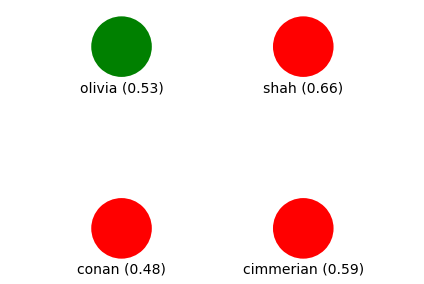

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


______________________________________________________________________________________________________________________________________________________
Howard_SchadowsinZamboula.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: conan
Frequency in story: 116
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: conan
Frequency in story: 116
Classified as NEGATIVE with average score of: 0.48842800691209975
-------------------------

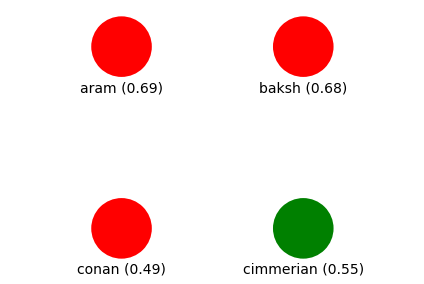

______________________________________________________________________________________________________________________________________________________
Doyle_TheSignoftheFour.json
______________________________________________________________________________________________________________________________________________________



No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: holmes
Frequency in story: 133
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: holmes
Frequency in story: 133
Classified as POSITIVE with average score of: 0.5349463645676923
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: sholto
Frequency in story: 75
----------

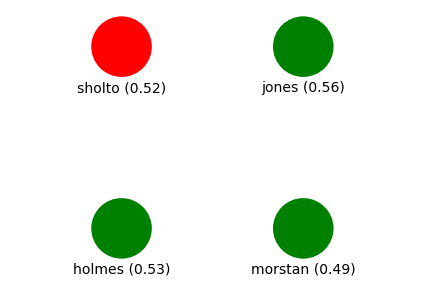

______________________________________________________________________________________________________________________________________________________
Kipling_TheJungleBook.json
______________________________________________________________________________________________________________________________________________________



No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: mowgli
Frequency in story: 205
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: mowgli
Frequency in story: 205
Classified as NEGATIVE with average score of: 0.6681175999525117
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: bagheera
Frequency in story: 125
-------

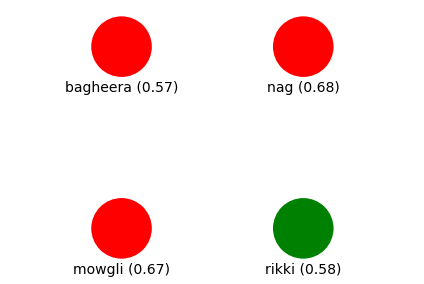

______________________________________________________________________________________________________________________________________________________
Doyle_TheHoundoftheBaskervilles.json
______________________________________________________________________________________________________________________________________________________



No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: holmes
Frequency in story: 191
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: holmes
Frequency in story: 191
Classified as POSITIVE with average score of: 0.5572636929482069
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: henry
Frequency in story: 156
----------

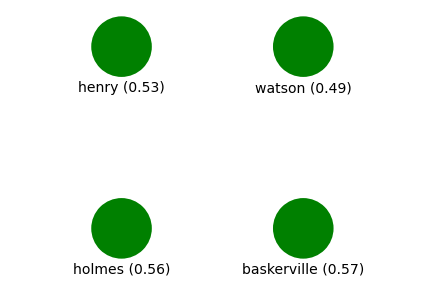

______________________________________________________________________________________________________________________________________________________
Lovecraft_TheCallofCthulu.json
______________________________________________________________________________________________________________________________________________________



No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: johansen
Frequency in story: 27
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: johansen
Frequency in story: 27
Classified as NEGATIVE with average score of: 0.6109546709943701
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: wilcox
Frequency in story: 24
--------

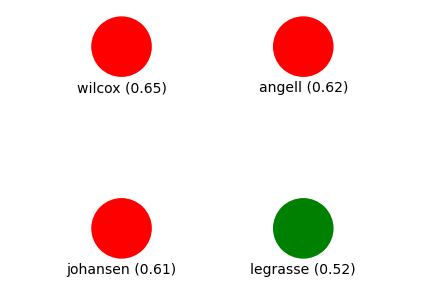

______________________________________________________________________________________________________________________________________________________
Lovecraft_TheShunnedHouse.json
______________________________________________________________________________________________________________________________________________________



No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: harris
Frequency in story: 32
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: harris
Frequency in story: 32
Classified as NEGATIVE with average score of: 0.5863212663680315
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: mercy
Frequency in story: 11
-------------

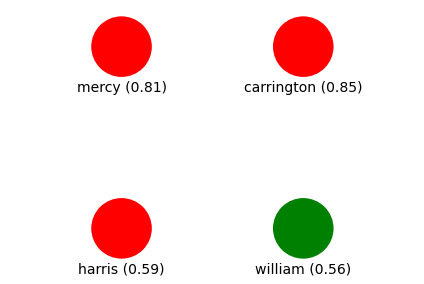

______________________________________________________________________________________________________________________________________________________
Doyle_AStudyinScarlet.json
______________________________________________________________________________________________________________________________________________________



No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: holmes
Frequency in story: 97
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: holmes
Frequency in story: 97
Classified as POSITIVE with average score of: 0.5821050940100679
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: drebber
Frequency in story: 62
-----------

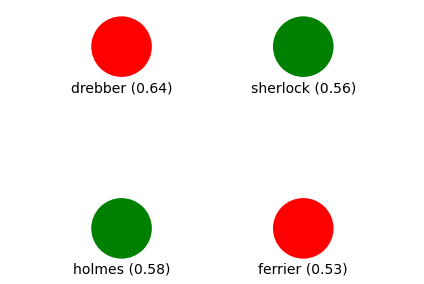

______________________________________________________________________________________________________________________________________________________
Kipling_ThyServantaDog.json
______________________________________________________________________________________________________________________________________________________



No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: moore
Frequency in story: 104
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: moore
Frequency in story: 104
Classified as NEGATIVE with average score of: 0.5219163103745532
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: toby
Frequency in story: 48
--------------

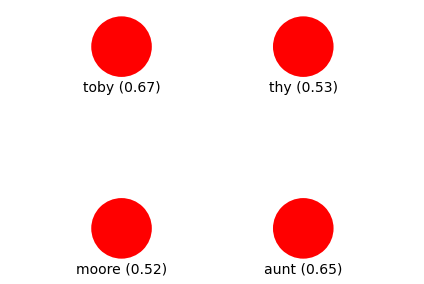

______________________________________________________________________________________________________________________________________________________
Lovecraft_AttheMountainofMadness.json
______________________________________________________________________________________________________________________________________________________



No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: danforth
Frequency in story: 60
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: danforth
Frequency in story: 60
Classified as NEGATIVE with average score of: 0.5842140128215155
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: pabodie
Frequency in story: 28
-------

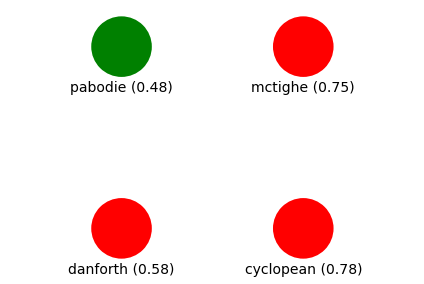

______________________________________________________________________________________________________________________________________________________
Kipling_TheEndofthePassage.json
______________________________________________________________________________________________________________________________________________________



No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: spurstow
Frequency in story: 60
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: spurstow
Frequency in story: 60
Classified as NEGATIVE with average score of: 0.6063133686780929
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: hummil
Frequency in story: 49
--------

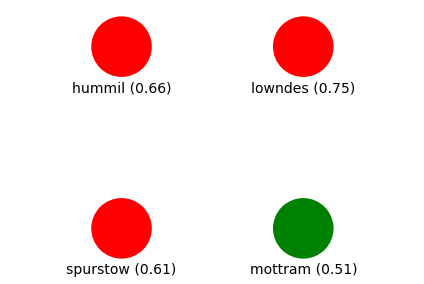

In [139]:
# gutenberg execution
path = "/content/drive/MyDrive/NLP-Project/data/gutenberg/"

main(path)

In [140]:
# Run this at the end

drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.
